# Introduction to Sentinel 2

**What does this notebook do?** This notebook steps you through how to load in and plot up data from Sentinel 2. It explores the data that are available from the Sentinel 2 satellite, and briefly describes the Sentinel satellite bands. It then loads in the `s2a_ard_granule` product and plots it up in true and false colour. It uses the provided pixel quality data to filters the example scene based on `cloud` and `cloud shadow`-free pixels. 

**Date**: November 2018

**Author**: Claire Krause, Robbi Bishop-Taylor

In [1]:
%matplotlib inline
from datacube.storage import masking #for pixel quality info  nb Sentinel 2 not good with detecting cloud becuase it doesn't have a NIR band
from datacube import Datacube
from datetime import datetime
from skimage import exposure
import matplotlib.pyplot as plt
import numpy as np
import sys
import os

# Point this to where you have the algorithms from the dea-notebooks/algorithms saved
sys.path.append(os.path.abspath('./scripts'))
#import DEAPlotting
import DEADataHandling

# Connect to datacube
dc = Datacube(app='Intro to Sentinel2')

## Sentinel 2 products currently available

In [2]:
products = dc.list_products()
display_columns = ['name', 'description', 'instrument',
                   'platform', 'product_type', 'crs', 'resolution']
sentinel_products = products[products['instrument'] == 'MSI'][display_columns]
sentinel_products

,name,description,instrument,platform,product_type,crs,resolution
id,,,,,,,
46,ga_s2a_ard_nbar_granule,Sentinel-2A MSI Definitive ARD - NBAR and Pixe...,MSI,SENTINEL_2A,S2MSIARD_NBAR,NaN,NaN
47,ga_s2b_ard_nbar_granule,Sentinel-2B MSI Definitive ARD - NBAR and Pixe...,MSI,SENTINEL_2B,S2MSIARD_NBAR,NaN,NaN
38,s2a_ard_granule,Sentinel-2A MSI ARD - NBAR NBART and Pixel Qua...,MSI,SENTINEL_2A,S2MSIARD,NaN,NaN
14,s2a_l1c_aws_pds,Sentinel-2A MSI L1C - AWS PDS,MSI,SENTINEL_2A,level1,NaN,NaN
36,s2a_level1c_granule,Sentinel-2A Level1C - Ortho Rectified Top of A...,MSI,Sentinel-2A,S2MSI1C,NaN,NaN
16,s2a_nrt_granule,Sentinel-2A MSI NRT - NBAR NBART and Pixel Qua...,MSI,SENTINEL_2A,ard,NaN,NaN
39,s2b_ard_granule,Sentinel-2B MSI ARD - NBAR NBART and Pixel Qua...,MSI,SENTINEL_2B,S2MSIARD,NaN,NaN
15,s2b_l1c_aws_pds,Sentinel-2B MSI L1C - AWS PDS,MSI,SENTINEL_2B,level1,NaN,NaN
37,s2b_level1c_granule,Sentinel-2B Level1C - Ortho Rectified Top of A...,MSI,Sentinel-2B,S2MSI1C,NaN,NaN


There are two spectral Sentinel satellites currently in DEA; **Sentinel-2A** and **Sentinel-2B**. Sentinel-2A was launched on 23 June 2015 and Sentinel-2B followed on 7 March 2017.

Both of the Sentinel 2 satellites carries an innovative wide swath high-resolution multispectral imager with 13 spectral bands. The mission is based on a constellation of two identical satellites in the same orbit, 180° apart for optimal coverage and data delivery. Together they cover all Earth's land surfaces, large islands, inland and coastal waters every five days at the equator.

For more information on the Sentinel 2 platforms and applications, check out the [European Space Agency website](http://www.esa.int/Our_Activities/Observing_the_Earth/Copernicus/Sentinel-2). 

## Loading Sentinel 2 data

We will focus on data from the Sentinel-2a platform for this demonstration, as there is more data available than 2b. To explore the spectral datasets from Sentinel-2a, we will use the `s2a_ard_granule` product. Sometimes multiple scenes are acquired by the satellite on the same day. We want to group these together, and will use `group_by='solar_day'` to do this.

To load in the Sentinel data, we have a number of options we can use in building our data extraction query:

* `lat`/`lon` - specify a bounding box for the extraction. Note that a polygon can be used instead. See [here](https://datacube-core.readthedocs.io/en/stable/dev/generate/datacube.api.query.Query.html#datacube.api.query.Query) for more details
* `output_crs` - the output coordinate reference system to project the data into. The CRS you request will impact on the format for the `resolution` query. Two handy CRSs are 'EPSG:3577', which is the Australian Albers projected coordinate system, and 'EPSG:4325', which is WGS84 a global geographic coordinate system.
* `resolution` - the requested output resolution for the data. If you have selected a geographic coordinate system for the `output_crs`, this will be in degrees. If you have selected a projected coordinate system, this will be in metres. 
* `time` - the time range for the query.

In [3]:
query = {
        'lat': (-42.77, -42.87),
        'lon': (147.55, 147.65),
        'output_crs': 'EPSG:3577',
        'resolution': (-20, 20),
        'time': ('2017-01-01', '2017-02-01')
        }

Canberra = dc.load(product='s2a_ard_granule', group_by='solar_day', **query)

### See what came back from the DEA query

In [4]:
Canberra
#Canberra.isel(time=0).to_array().plot.imshow(robust=True, figsize=(6,6))

<xarray.Dataset>
Dimensions:                (time: 3, x: 485, y: 587)
Coordinates:
  * time                   (time) datetime64[ns] 2017-01-05T00:02:12.026000 ... 2017-01-25T00:08:31.026000
  * y                      (y) float64 -4.755e+06 -4.755e+06 ... -4.766e+06
  * x                      (x) float64 1.307e+06 1.307e+06 ... 1.317e+06
Data variables:
    azimuthal_exiting      (time, y, x) float32 -76.590706 ... 70.23032
    azimuthal_incident     (time, y, x) float32 -36.99386 -46.14321 ... 61.89015
    exiting                (time, y, x) float32 0.0 0.16312942 ... 7.511257
    incident               (time, y, x) float32 33.98935 33.85645 ... 45.63784
    relative_azimuth       (time, y, x) float32 218.9346 218.93489 ... 221.76427
    relative_slope         (time, y, x) float32 39.596848 ... -8.340176
    satellite_azimuth      (time, y, x) float32 281.74258 ... 281.75833
    satellite_view         (time, y, x) float32 0.9629098 ... 1.8684446
    solar_azimuth          (time, y, x) float32 62.80798 62.80769 ... 59.994064
    solar_zenith           (time, y, x) float32 33.198605 ... 36.807167
    terrain_shadow         (time, y, x) uint8 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1
    fmask                  (time, y, x) uint8 3 3 2 2 2 2 2 2 ... 1 1 1 1 1 1 1
    nbar_contiguity        (time, y, x) uint8 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1
    nbar_coastal_aerosol   (time, y, x) int16 966 966 966 902 ... 535 543 543
    nbar_blue              (time, y, x) int16 1109 950 841 927 ... 406 541 490
    nbar_green             (time, y, x) int16 1385 1150 966 1021 ... 580 757 690
    nbar_red               (time, y, x) int16 1961 1565 1277 ... 566 806 781
    nbar_red_edge_1        (time, y, x) int16 2024 1899 1548 ... 1171 1316 1227
    nbar_red_edge_2        (time, y, x) int16 2241 2106 1723 ... 2068 2150 1913
    nbar_red_edge_3        (time, y, x) int16 2541 2360 1969 ... 2360 2376 2185
    nbar_nir_1             (time, y, x) int16 2864 2277 1843 ... 2436 2671 2460
    nbar_nir_2             (time, y, x) int16 2944 2735 2237 ... 2744 2766 2567
    nbar_swir_2            (time, y, x) int16 2710 2284 1890 ... 2102 2337 2243
    nbar_swir_3            (time, y, x) int16 1797 1498 1173 ... 1274 1382 1309
    nbart_contiguity       (time, y, x) uint8 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1
    nbart_coastal_aerosol  (time, y, x) int16 969 969 969 902 ... 541 572 572
    nbart_blue             (time, y, x) int16 1118 953 842 924 ... 418 577 543
    nbart_green            (time, y, x) int16 1396 1153 967 1018 ... 597 810 768
    nbart_red              (time, y, x) int16 1978 1570 1278 ... 584 866 875
    nbart_red_edge_1       (time, y, x) int16 2042 1912 1554 ... 1224 1427 1372
    nbart_red_edge_2       (time, y, x) int16 2260 2121 1730 ... 2162 2330 2138
    nbart_red_edge_3       (time, y, x) int16 2560 2374 1975 ... 2457 2555 2415
    nbart_nir_1            (time, y, x) int16 2885 2283 1844 ... 2506 2849 2723
    nbart_nir_2            (time, y, x) int16 2965 2751 2245 ... 2857 2975 2837
    nbart_swir_2           (time, y, x) int16 2733 2300 1897 ... 2204 2547 2524
    nbart_swir_3           (time, y, x) int16 1813 1508 1178 ... 1339 1513 1484
Attributes:
    crs:      EPSG:3577

### Sentinel 2 bands
Sentinel 2 satellites have 13 spectral channels:

| Sentinel 2 bands | DEA band name | Band number | Central wavelength (nm) | Resolution (m) | Bandwidth (nm) |
| -----------------|---------------|-------------|-------------------------|----------------|----------------|
| Coastal aerosol | `nbar(t)_coastal_aerosol` | 1 | 443 | 60 | 20 |
| Blue | `nbar(t)_blue` | 2 | 490 | 10 | 65 |
| Green | `nbar(t)_green` | 3 | 560 | 10 | 35 |
| Red | `nbar(t)_red` | 4 | 665 | 10 | 30 |
| Vegetation red edge | `nbar(t)_red_edge_1` | 5 | 705 | 20 | 15 |
| Vegetation red edge | `nbar(t)_red_edge_2` | 6 | 740 | 20 | 15 |
| Vegetation red edge | `nbar(t)_red_edge_3` | 7 | 783 | 20 | 20 |
| NIR | `nbar(t)_nir_1` | 8 | 842 | 10 | 115 |
| Narrow NIR | `nbar(t)_nir_2` | 8A | 865 | 20 | 20 |
| Water vapour | N/A | 9 | 945 | 60 | 20 |
| SWIR - Cirrus | N/A | 10 | 1375 | 60 | 20 |
| SWIR | `nbar(t)_swir_2` | 11 | 1610 | 20 | 90 |
| SWIR | `nbar(t)_swir_3` | 12 | 2190 | 20 | 180 |

These bands cover the visible, near-infrared and short-wave infrared wave lengths.

![Sentinel 2 bands](http://www.geosage.com/highview/figures/Sentinel2_Spectral_Bands.jpg)

**Note** There are a number of additional datasets that are alse returned from our query. These are a combination of datasets used in the correction process, and layers relating to pixel quality. We will explore the pixel quality layers below.

### Data corrections

There are two corrections applied to the Sentinel data:

1. **NBAR (e.g. `nbar_green`)**  
NBAR stands for Nadir-corrected BRDF Adjusted Reflectance, where BRDF stands for Bidirectional reflectance distribution function The approach involves atmospheric correction to compute surface-leaving radiance, and bi-directional reflectance modelling to remove the effects of topography and angular variation in reflectance.

2. **T_NBAR (e.g. `nbart_green`)**  
Surface reflectance T_NBAR includes the terrain illumination reflectance correction and has the same features of NBAR, along with some additional features.

For more information on these corrections, see the explanation on the [DEA surface reflectance page](http://geoscienceaustralia.github.io/digitalearthau/data/data.html#). 

### Dealing with missing data

Note that the `nbart` data insert a missing value (`-9999`) into the dataset to denote a terrain shadow. This should be converted to a `NaN` value before using this data to avoid treating it as a valid value:



In [5]:
Canberra = masking.mask_invalid_data(Canberra)

### Plot as a true colour image

True colour images approximate what the human eye sees when looking at a landscape. Note that the function used for this true colour plot enhances the contrast between the bands, resulting in a colour-enhanced image.

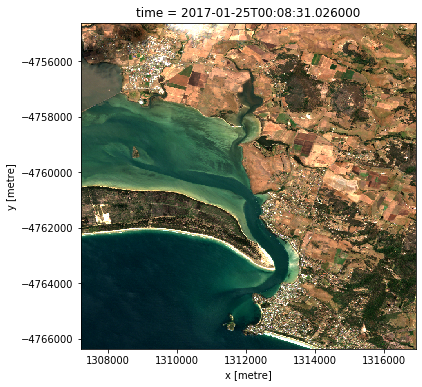

In [6]:
Canberra[['nbart_red', 'nbart_green', 'nbart_blue']].isel(time=2).to_array().plot.imshow(robust=True, figsize=(6,6))

### Plot as a false colour image

This plot uses the SWIR, NIR and green bands to accentuate the presence of water in the landscape.

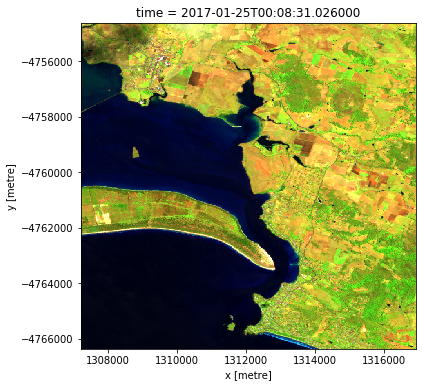

In [7]:
Canberra[['nbart_swir_2', 'nbart_nir_1', 'nbart_green']].isel(time=2).to_array().plot.imshow(robust=True, figsize=(6,6))

### Compare observations side-by-side

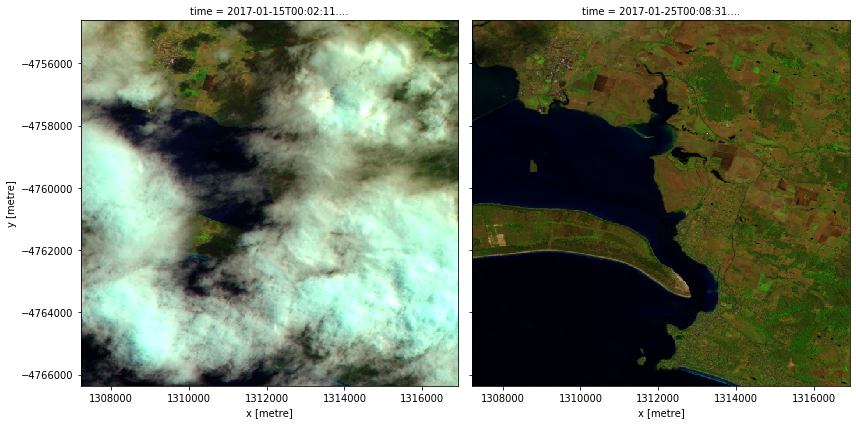

In [8]:
Canberra[['nbart_swir_2', 'nbart_nir_1', 'nbart_green']].isel(time=slice(1,3)).to_array().plot.imshow('x', 'y', col='time', col_wrap=2, robust=True, figsize=(12,6))


## Filter scenes using pixel quality

A pixel quality dataset (`fmask`) is provided alongside the spectral data, which can be used to filter out noisy pixels. The key things we want to filter are clouds and shadows. 

The `fmask` field contains values from 0 to 5. 

| Value | Description |
|-------|-------------|
| 0 | Null |
| 1 | Valid |
| 2 | Cloud |
| 3 | Cloud shadow |
| 4 | Snow |
| 5 | Water |

Here is the cloudy image we would like to mask:

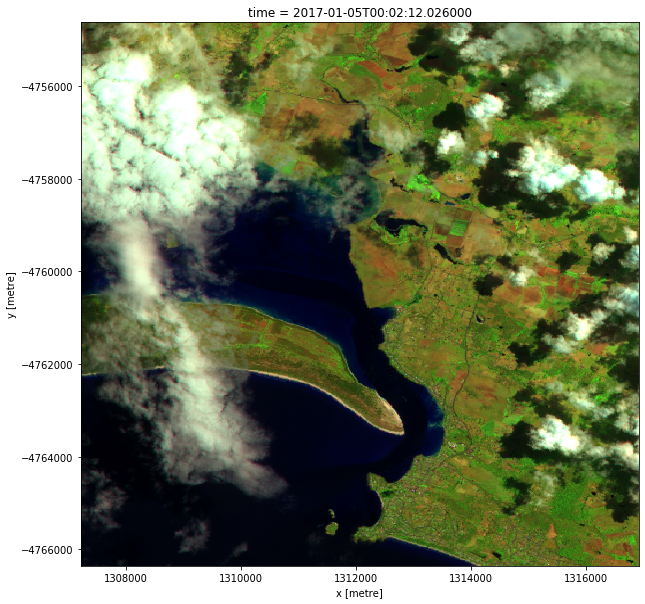

In [9]:
Canberra[['nbart_swir_2', 'nbart_nir_1', 'nbart_green']].isel(time=0).to_array().plot.imshow(robust=True, figsize=(10,10))

### Plot pixel quality information 
Here we plot pixel quality information that corresponds to the observation above. This data is stored in the `fmask` variable:

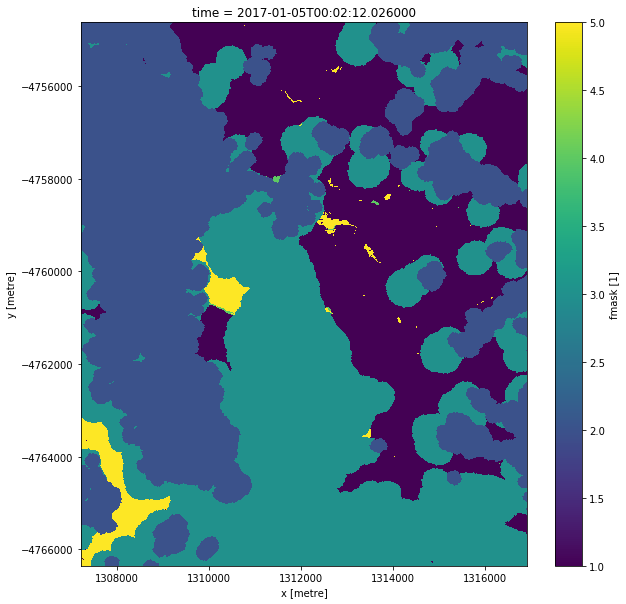

In [10]:
Canberra.isel(time=0).fmask.plot(figsize=[10, 10])

### Use pixel quality information to create a mask, and apply it to the spectral data

We want to filter out no data, cloud and cloud shadow, so we will use the `fmask` values `0`, `2` and `3` for our filter.

In [11]:
# Numpy's `isin` function tests whether a pixel's value is in `test_elements`. Because we want to 
# discard pixels where this is the case (because these pixels represent nodata, cloud or cloud shadow),
# we also use `invert=True` to keep only good quality pixels
clear_pixels = np.isin(Canberra.fmask, test_elements=[0, 2, 3], invert=True)

# Use clear pixels as a mask to keep only clear pixels
Clear_Canberra = Canberra.where(clear_pixels)

### Plot cloud-masked image

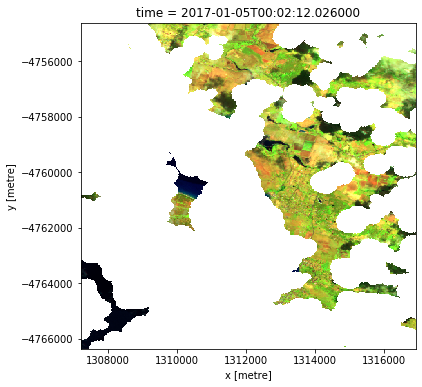

In [12]:
Clear_Canberra[['nbart_swir_2', 'nbart_nir_1', 'nbart_green']].isel(time=0).to_array().plot.imshow(robust=True, figsize=(6,6))

## Use `load_clearsentinel2` to automatically load cloud free observations
To make loading Sentinel 2 data more convenient, the `load_clearsentinel2` function was written to automate common tasks like returning cloud-free time series:

In [13]:
query = {
        'lat': (-42.77, -42.87),
        'lon': (147.55, 147.65),
        'output_crs': 'EPSG:3577',
        'resolution': (-10, 10),
        'time': ('2017-01-01', '2017-02-01')
        }

# The `load_clearsentinel2` can be given a query containing spatial and temporal bounds, and a list of bands to return.
# By setting `mask_pixel_quality=True`, the function will automatically remove nodata, cloud or cloud shadow pixels:
Clear_Canberra = DEADataHandling.load_clearsentinel2(dc=dc,
                                                     query=query,
                                                     bands_of_interest=('nbart_red', 'nbart_green', 'nbart_blue', 
                                                                        'nbart_nir_1', 'nbart_swir_2', 'nbart_swir_3'),
                                                     masked_prop=0,
                                                     mask_pixel_quality=True)

Clear_Canberra

Loading s2a pixel quality
    Loading 3 filtered s2a timesteps
Loading s2b pixel quality
    Skipping s2b; no valid data for query
Combining and sorting s2a data
    Replacing invalid -999 values with NaN (data will be coerced to float64)


<xarray.Dataset>
Dimensions:       (time: 3, x: 969, y: 1173)
Coordinates:
  * time          (time) datetime64[ns] 2017-01-05T00:02:12.026000 ... 2017-01-25T00:08:31.026000
  * y             (y) float64 -4.755e+06 -4.755e+06 ... -4.766e+06 -4.766e+06
  * x             (x) float64 1.307e+06 1.307e+06 ... 1.317e+06 1.317e+06
Data variables:
    nbart_red     (time, y, x) float64 nan nan nan nan ... 759.0 866.0 915.0
    nbart_green   (time, y, x) float64 nan nan nan nan ... 721.0 810.0 819.0
    nbart_blue    (time, y, x) float64 nan nan nan nan ... 541.0 577.0 593.0
    nbart_nir_1   (time, y, x) float64 nan nan nan ... 2.849e+03 2.829e+03
    nbart_swir_2  (time, y, x) float64 nan nan nan ... 2.547e+03 2.547e+03
    nbart_swir_3  (time, y, x) float64 nan nan nan ... 1.513e+03 1.513e+03
    data_perc     (time, y, x) float64 nan nan nan nan ... 0.9546 0.9546 0.9546
Attributes:
    crs:      EPSG:3577

We can plot the same observation as earlier to verify we get the same result:

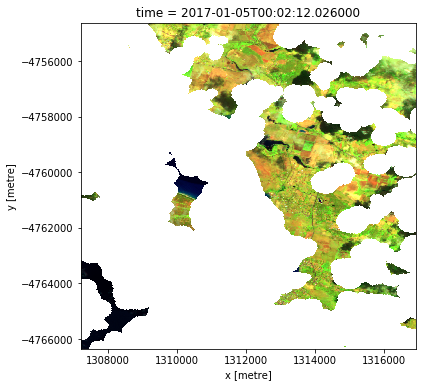

In [14]:
Clear_Canberra[['nbart_swir_2', 'nbart_nir_1', 'nbart_green']].isel(time=0).to_array().plot.imshow(robust=True, figsize=(6,6))

### Returning only cloud-free images
The `load_clearsentinel2` function also allows you to return only images that contain greater than a given percentage of good quality pixels. For example, this can be used to return only cloud-free images. To do this, we specify a minimum proportion of good pixels using the `masked_prop` argument (e.g. specifying 0.3 below will return only images with more than 30% good quality, cloud-free pixels).

**Please note:** the Sentinel 2 cloud masking algorithm currently performs poorly over urban areas, where it commonly confuses buildings with clouds. Because of this, you make need to use a small value for `masked_prop` to ensure the algorithm does not discard an excessive number of images.

In [15]:
query = {
        'lat': (-42.77, -42.87),
        'lon': (147.55, 147.65),
        'output_crs': 'EPSG:3577',
        'resolution': (-10, 10),
        'time': ('2018-01-01', '2019-02-01')
        }

Clear_Uluru = DEADataHandling.load_clearsentinel2(dc=dc,
                                                     query=query,
                                                     bands_of_interest=('nbart_red', 'nbart_green', 'nbart_blue', 
                                                                        'nbart_nir_1', 'nbart_swir_2', 'nbart_swir_3'),
                                                     masked_prop=0.3)

Clear_Uluru

Loading s2a pixel quality
    Loading 11 filtered s2a timesteps
Loading s2b pixel quality
    Loading 15 filtered s2b timesteps
Combining and sorting s2a, s2b data
    Replacing invalid -999 values with NaN (data will be coerced to float64)


<xarray.Dataset>
Dimensions:       (time: 26, x: 969, y: 1173)
Coordinates:
  * x             (x) float64 1.307e+06 1.307e+06 ... 1.317e+06 1.317e+06
  * y             (y) float64 -4.755e+06 -4.755e+06 ... -4.766e+06 -4.766e+06
  * time          (time) datetime64[ns] 2018-01-05T00:02:29.027000 ... 2019-01-15T00:02:41.024000
Data variables:
    nbart_red     (time, y, x) float64 1.28e+03 1.353e+03 ... 1.316e+03
    nbart_green   (time, y, x) float64 1.006e+03 1.061e+03 ... 930.0 970.0
    nbart_blue    (time, y, x) float64 943.0 933.0 961.0 ... 700.0 786.0 813.0
    nbart_nir_1   (time, y, x) float64 1.963e+03 2.079e+03 ... 2.321e+03
    nbart_swir_2  (time, y, x) float64 2.718e+03 3.238e+03 ... 3.149e+03
    nbart_swir_3  (time, y, x) float64 2.109e+03 2.449e+03 ... 2.217e+03
    data_perc     (time, y, x) float64 0.842 0.842 0.842 ... 0.3547 0.3547
Attributes:
    crs:      EPSG:3577

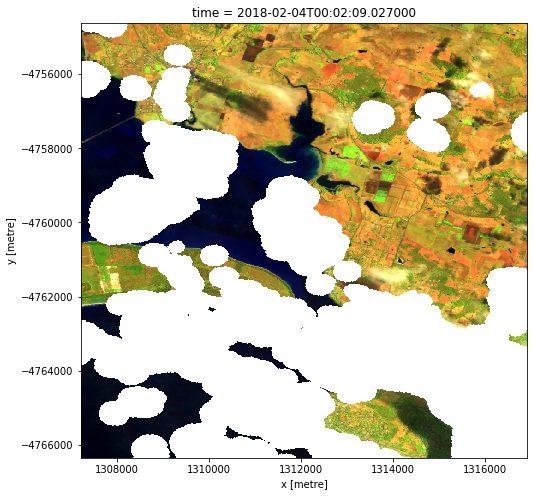

In [16]:
Clear_Uluru[['nbart_swir_2', 'nbart_nir_1', 'nbart_green']].isel(time=2).to_array().plot.imshow(robust=True, figsize=(8,8))


### Are you curious about seeing any other places in Australia in high-res?

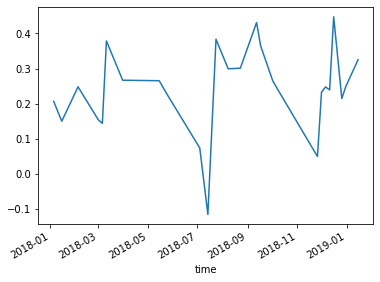

In [17]:
ndvi_uluru = (Clear_Uluru.nbart_nir_1-Clear_Uluru.nbart_red)/(Clear_Uluru.nbart_nir_1+Clear_Uluru.nbart_red)
ndvi_uluru.mean(dim=['x','y']).plot()

In [3]:
%matplotlib inline
from datacube.storage import masking #for pixel quality info  nb Sentinel 2 not good with detecting cloud becuase it doesn't have a NIR band
from datacube import Datacube
from datetime import datetime
from skimage import exposure
import matplotlib.pyplot as plt
import numpy as np
import sys
import os

# Point this to where you have the algorithms from the dea-notebooks/algorithms saved
sys.path.append(os.path.abspath('./scripts'))
#import DEAPlotting
import DEADataHandling

# Connect to datacube
dc = Datacube(app='Intro to Sentinel2')



query = { 'lat': (-27.25, -27.35),
        'lon': (152.05 , 152.20),
        'output_crs': 'EPSG:3577',
        'resolution': (-20, 20),
        'time': ('2019-10-01', '2019-11-30')}

Clear_Fire = DEADataHandling.load_clearsentinel2(dc=dc,
                                                     query=query,
                                                     bands_of_interest=('nbart_red', 'nbart_green', 'nbart_blue', 
                                                                        'nbart_nir_1', 'nbart_swir_2', 'nbart_swir_3'),
                                                     masked_prop=0.3)

Clear_Fire

Loading s2a pixel quality
    Loading 3 filtered s2a timesteps
Loading s2b pixel quality
    Loading 2 filtered s2b timesteps
Combining and sorting s2a, s2b data
    Replacing invalid -999 values with NaN (data will be coerced to float64)


<xarray.Dataset>
Dimensions:       (time: 5, x: 813, y: 670)
Coordinates:
  * y             (y) float64 -3.108e+06 -3.108e+06 ... -3.122e+06 -3.122e+06
  * x             (x) float64 1.952e+06 1.952e+06 ... 1.968e+06 1.968e+06
  * time          (time) datetime64[ns] 2019-10-17T00:02:39.024000 ... 2019-11-21T00:02:41.024000
Data variables:
    nbart_red     (time, y, x) float64 1.146e+03 1.244e+03 ... 799.0 727.0
    nbart_green   (time, y, x) float64 915.0 987.0 990.0 ... 751.0 786.0 715.0
    nbart_blue    (time, y, x) float64 704.0 769.0 757.0 ... 729.0 740.0 686.0
    nbart_nir_1   (time, y, x) float64 2.337e+03 2.453e+03 ... 1.769e+03
    nbart_swir_2  (time, y, x) float64 4.087e+03 4.317e+03 ... 1.822e+03
    nbart_swir_3  (time, y, x) float64 3.067e+03 3.251e+03 ... 1.104e+03
    data_perc     (time, y, x) float64 0.9917 0.9917 0.9917 ... 0.8884 0.8884
Attributes:
    crs:      EPSG:3577

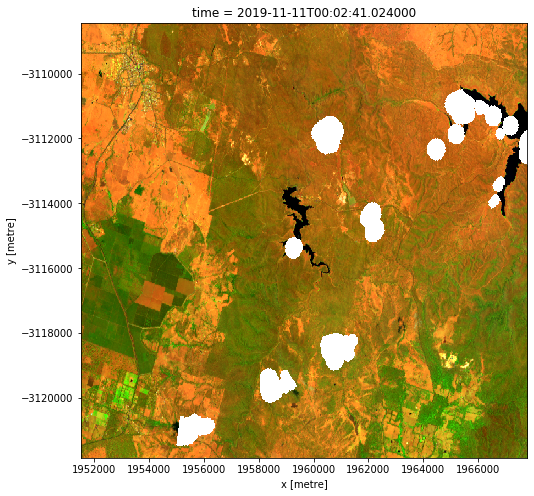

In [4]:
Clear_Fire[['nbart_swir_2', 'nbart_nir_1', 'nbart_green']].isel(time=2).to_array().plot.imshow(robust=True, figsize=(8,8))

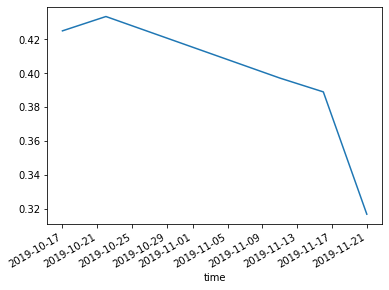

In [5]:
ndvi_petchy = (Clear_Fire.nbart_nir_1-Clear_Fire.nbart_red)/(Clear_Fire.nbart_nir_1+Clear_Fire.nbart_red)
ndvi_petchy.mean(dim=['x','y']).plot()

#ndvi_petchy.plot.imshow(robust=True, figsize=(8,8)

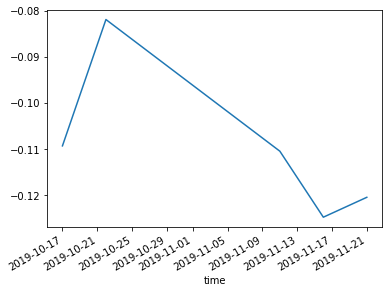

In [6]:
nbr_petchy = (Clear_Fire.nbart_nir_1-Clear_Fire.nbart_swir_2)/(Clear_Fire.nbart_nir_1+Clear_Fire.nbart_swir_2)
nbr_petchy.mean(dim=['x','y']).plot()

In [20]:

import matplotlib.pyplot as plt
import numpy as np
import sys
import os
plt.imshow(nbr_petchy.isel(time=3).values,cmap = 'summer_r')

#nbr_petchy.["nbart_red"].plot(col='time', col_wrap=5)

SyntaxError: invalid syntax (<ipython-input-20-1b5fb67c203b>, line 7)